In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'C:\\Users\\Benson\\Desktop\\new_lyft_2022'

In [3]:
FOLDERPATH = os.getcwd() +"\\lyftlong\\"

In [4]:
agents_df = pd.read_csv(FOLDERPATH + 'rand_agents_table0.csv')
frame_df = pd.read_csv(FOLDERPATH + 'rand_frames_table1.csv')
scene_df = pd.read_csv(FOLDERPATH + 'rand_scenes_table1.csv')

In [5]:
lanes_df = pd.read_csv(FOLDERPATH+"lanes_table0.csv")

In [6]:
cw_df_orig = pd.read_csv(FOLDERPATH + "crosswalks_table0.csv")
cw_df = cw_df_orig.copy()

import seaborn as sns
sns.color_palette("rocket", as_cmap=True)

In [7]:
from sklearn.preprocessing import normalize

In [96]:
from matplotlib.path import Path

In [8]:
from PIL import Image
Actual_roadmap = Image.open(FOLDERPATH + "\\palo_alto_proper_blurred.png").convert("L")

Actual_roadmap_arr = np.array(Actual_roadmap)

#Actual_roadmap_arr[:,0] += 1285
#Actual_roadmap_arr[:,1] += 2778

def GET_ROADMAP_ADJUSTER_X():
    return 1285
def GET_ROADMAP_ADJUSTER_Y():
    return 2770
def VERTICES_ADJUSTMENT(row_vertices, SHIFT_X=None, SHIFT_Y=None):
    # Either shifting to roadmap, or for agent
    #print(row_vertices)
    SHIFT_X = GET_ROADMAP_ADJUSTER_X()
    SHIFT_Y = GET_ROADMAP_ADJUSTER_Y()
    row_vertices[:,0] += SHIFT_X
    row_vertices[:,1] += SHIFT_Y
    return row_vertices

### Data Cleaning
* Proper obtainment of roadmap, and then blur, On-road column
* Crosswalk
* disance to ai-agents (does it need to be ai-agent?)
* yaw dotprod with agents for other lane (only nearby)
* trajectory intersection and geometry
* Look for possible data errors:
    * Extent x and y, wrt category:
        * Federal length or width
        * Length over width ratio
    * Velocity: Incorrect or weird Outliers, wrt category
    * Check if agents change in extent, category over period in a scene:
        * account for category type
        * account for frame appearance percentage (to see if droppable)
        * account for distance from "main" agent (to see if droppable)
        
    * Check if agents change in category over period in a scene
* removal necessary for , but see if it would overly affect the current data
* drop one time cars? unless too important to scene
* Data Imputation per scene track id of Unknown with Random Foresting, using speed, extents, onroad (post-cleaned)

#### Prediction
- Controllable Inputs
    * Yaw (Angle)
    * Magnitude


- Non-Controllable Inputs
    * Preceding History
    * Location (onroad, off-road)
    * Agent type
    * Size?
- Issue:
    * How to aggregate variable inputs (cars?)

In [9]:
from PIL import Image
Actual_roadmap = Image.open(FOLDERPATH + "\\palo_alto_proper_blurred.png").convert("L")

In [10]:
lanes_df["lane_coord_z"].std()/lanes_df["lane_coord_z"].mean()

0.024935918497544767

In [11]:
lanes_df_arr = lanes_df[["lane_coord_x","lane_coord_y"]].values

In [12]:
ACTUAL_ROADMAP_ARR = Actual_roadmap_arr * (1/255)
ACTUAL_ROADMAP_ARR = 1- ACTUAL_ROADMAP_ARR
ACTUAL_ROADMAP_ARR = ACTUAL_ROADMAP_ARR[::-1]

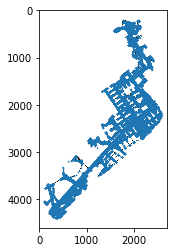

In [13]:
lanes_df_arr = VERTICES_ADJUSTMENT(lanes_df_arr)
plt.scatter(lanes_df_arr[:,0],lanes_df_arr[:,1],s=0.05)
plt.imshow(Actual_roadmap_arr[::-1],cmap="gray")

In [14]:
LANES_DF = lanes_df[["lane_coord_x","lane_coord_y"]].astype(int)

In [15]:
def is_on_road(x, y):
    # get shade (0 to 1) at pixel xy on the roadmap
    return ACTUAL_ROADMAP_ARR[y][x]

In [16]:
def configure_roadmap_lane_coords(X_ADJUSTMENT, Y_ADJUSTMENT):
    """
    Will be used to find how well-aligned the roadmap and lane-coords are, in terms of our manual adjustments
    Args:
        X_ADJUSTMENT (float): x-axis translation of the lane coordinates
        Y_ADJUSTMENT (float): y-axis translation of the lane coordinates
    Returns:
        Float showing alignment score
    """
    alignment_scores = LANES_DF.apply(lambda df: is_on_road(
        df["lane_coord_x"]+X_ADJUSTMENT,
        df["lane_coord_y"]+Y_ADJUSTMENT), axis=1)
    mean_alignment_score = alignment_scores.mean()
    return mean_alignment_score

In [17]:
configure_roadmap_lane_coords(1285,2770)

0.7422405274041679

X_ADJUSTMENT_DOMAIN = np.arange(1283, 1287+1, 1)
Y_ADJUSTMENT_DOMAIN = np.arange(2768, 2772+1, 1)

X_ADJUSTMENTS = []
Y_ADJUSTMENTS = []
MEAN_ALIGNMENT_SCORES = []
for X_ADJUSTMENT in X_ADJUSTMENT_DOMAIN:
    for Y_ADJUSTMENT in Y_ADJUSTMENT_DOMAIN:
        X_ADJUSTMENTS.append(X_ADJUSTMENT)
        Y_ADJUSTMENTS.append(Y_ADJUSTMENT)
        MEAN_ALIGNMENT_SCORE = configure_roadmap_lane_coords(X_ADJUSTMENT, Y_ADJUSTMENT)
        MEAN_ALIGNMENT_SCORES.append(MEAN_ALIGNMENT_SCORE)
        print(len(MEAN_ALIGNMENT_SCORES), X_ADJUSTMENT, Y_ADJUSTMENT, MEAN_ALIGNMENT_SCORE)

#The optimal is x = 1285,  = 2770, giving the score: 0.7422405274041679

configuration_adjustments_df = pd.DataFrame()
configuration_adjustments_df["X_Adjust"] = np.sort(np.tile(X_ADJUSTMENTS,(7)))
configuration_adjustments_df["Y_Adjust"] = Y_ADJUSTMENTS
configuration_adjustments_df["Alignment_Score"] = MEAN_ALIGNMENT_SCORES

#configuration_adjustments_df.
adjustments_heatmap = pd.pivot(configuration_adjustments_df, index="X_Adjust",columns="Y_Adjust",values="Alignment_Score")


adjustments_heatmap.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

In [16]:
def get_angle_with_drv_vector(x, y):
    return 2*np.arctan(y/(x + np.sqrt((x**2) + (y**2))))

# https://www.kaggle.com/competitions/lyft-motion-prediction-autonomous-vehicles/discussion/192304
# each frame = 1/10 second #velocity is meters per second
FPS_CONVERSION = 1/(0.1)
frame_df["centroid_x"] = frame_df["ego_translation_x"].values
frame_df["centroid_y"] = frame_df["ego_translation_y"].values
velocity_x = (frame_df["ego_translation_x"]-frame_df["ego_translation_x"].shift(1)) * (FPS_CONVERSION)
velocity_y = (frame_df["ego_translation_y"]-frame_df["ego_translation_y"].shift(1)) * (FPS_CONVERSION)
boundary_indices = frame_df["scene_index"].drop_duplicates().index
#boundary_indices
velocity_x.iloc[boundary_indices,] = np.nan
velocity_y.iloc[boundary_indices,] = np.nan

yaw = get_angle_with_drv_vector(velocity_x,velocity_y) # from -3.12 to 3.0
EGO_EXTENT_WIDTH = 1.85
EGO_EXTENT_LENGTH = 4.87
EGO_EXTENT_HEIGHT = 1.8
EGO_EXTENT_Y = EGO_EXTENT_WIDTH
EGO_EXTENT_X = EGO_EXTENT_LENGTH
EGO_EXTENT_Z = EGO_EXTENT_HEIGHT
EGO_TRACK_ID = 0

# we can make it 0, agents_df["track_id"].min() is 1

frame_df["velocity_x"] = velocity_x
frame_df["velocity_y"] = velocity_y
frame_df["yaw"] = yaw
frame_df["track_id"] = EGO_TRACK_ID
frame_df["extent_y"] = EGO_EXTENT_Y
frame_df["extent_x"] = EGO_EXTENT_X
frame_df["extent_z"] = EGO_EXTENT_Z
frame_df['PERCEPTION_LABEL_CAR'] = 1

# revisit
other_label_column_names_unused = ['PERCEPTION_LABEL_NOT_SET', 'PERCEPTION_LABEL_DONTCARE',
 'PERCEPTION_LABEL_VAN', 'PERCEPTION_LABEL_TRAM', 'PERCEPTION_LABEL_BUS',
 'PERCEPTION_LABEL_TRUCK', 'PERCEPTION_LABEL_EMERGENCY_VEHICLE',
 'PERCEPTION_LABEL_OTHER_VEHICLE', 'PERCEPTION_LABEL_BICYCLE',
 'PERCEPTION_LABEL_MOTORCYCLE',
 'PERCEPTION_LABEL_MOTORCYCLIST', 'PERCEPTION_LABEL_ANIMAL', 'AVRESEARCH_LABEL_DONTCARE']

other_label_column_names = []
other_label_column_names += ["PERCEPTION_LABEL_CYCLIST","PERCEPTION_LABEL_UNKNOWN","PERCEPTION_LABEL_PEDESTRIAN"]
other_label_column_names += other_label_column_names_unused
for column_name in other_label_column_names:
    frame_df[column_name] = 0



frame_df_agentizedHostcar_joining_column_names = []
frame_df_agentizedHostcar_joining_column_names += ["centroid_x"]
frame_df_agentizedHostcar_joining_column_names += ["centroid_y"]
frame_df_agentizedHostcar_joining_column_names += ["velocity_x"]
frame_df_agentizedHostcar_joining_column_names += ["velocity_y"]
frame_df_agentizedHostcar_joining_column_names += ["yaw"]
frame_df_agentizedHostcar_joining_column_names += ["track_id"]
frame_df_agentizedHostcar_joining_column_names += ["extent_y"]
frame_df_agentizedHostcar_joining_column_names += ["extent_x"]
frame_df_agentizedHostcar_joining_column_names += ["extent_z"]
frame_df_agentizedHostcar_joining_column_names += ["PERCEPTION_LABEL_CAR"]
frame_df_agentizedHostcar_joining_column_names += ["scene_index"]
frame_df_agentizedHostcar_joining_column_names += ["frame_index"]
frame_df_agentizedHostcar_joining_column_names += other_label_column_names

frame_df_agentizedHostcar_joining = frame_df[frame_df_agentizedHostcar_joining_column_names]

# Due to how velocity was calculated, there's a nan gap at 1st frames of scene, for certain columns
# we will drop these rows, effectively removing the 1st frame from each scene
temp_df = frame_df_agentizedHostcar_joining
boundary_issue_column_names = []
boundary_issue_column_names += ["velocity_x"]
boundary_issue_column_names += ["velocity_y"]
boundary_issue_column_names += ["yaw"]
#temp_df = temp_df.dropna(subset=boundary_issue_column_names)
temp_df = temp_df.fillna(method="ffill")
frame_df_agentizedHostcar_joining = temp_df

scene_frame_agents_df_concat = []
scene_frame_agents_df_concat += [agents_df.merge(frame_df[["frame_index","scene_index"]],on=["frame_index"])]
scene_frame_agents_df_concat += [frame_df_agentizedHostcar_joining]
scene_frame_agents_df = pd.concat(scene_frame_agents_df_concat,axis=0)

scene_frame_agents_df = scene_frame_agents_df.sort_values(["scene_index","frame_index","track_id"])

In [17]:
scene_frame_agents_df_unneeded_column_names = []
scene_frame_agents_df_unneeded_column_names += ["extent_z"]
scene_frame_agents_df_unneeded_column_names += other_label_column_names_unused

scene_frame_agents_df = scene_frame_agents_df.drop(columns= scene_frame_agents_df_unneeded_column_names)

In [ ]:
temp_df = scene_frame_agents_df
temp_df["is_on_road"] = temp_df[["centroid_x","centroid_y"]].astype(int).apply(lambda df: is_on_road(
        df["centroid_x"]+GET_ROADMAP_ADJUSTER_X(),
        df["centroid_y"]+GET_ROADMAP_ADJUSTER_Y()), axis=1)
scene_frame_agents_df = temp_df

In [ ]:
#scene_frame_agents_df.to_csv(FOLDERPATH+"scene_frame_agents_df_2022.csv",index=False)

### JUMP TO HERE

In [18]:
scene_frame_agents_df = pd.read_csv(FOLDERPATH+"scene_frame_agents_df_2022.csv")

In [19]:
scene_frame_agents_df

,centroid_x,centroid_y,extent_x,extent_y,velocity_x,velocity_y,yaw,track_id,PERCEPTION_LABEL_UNKNOWN,PERCEPTION_LABEL_CAR,PERCEPTION_LABEL_CYCLIST,PERCEPTION_LABEL_PEDESTRIAN,frame_index,scene_index,is_on_road
0,-543.986938,904.397095,4.870000,1.850000,-7.902222,8.685608,2.309003,0,0.0,1.0,0.0,0.0,27814,112,0.313725
1,-551.432678,912.519104,4.876464,1.911275,0.000000,0.000000,-0.838672,1,0.0,1.0,0.0,0.0,27814,112,0.196078
2,-539.526184,915.301514,4.519358,1.827863,0.000000,0.000000,-0.824665,2,0.0,1.0,0.0,0.0,27814,112,0.945098
3,-522.900513,892.094666,4.532728,1.837899,0.000000,0.000000,-0.818223,3,0.0,1.0,0.0,0.0,27814,112,0.788235
4,-530.089539,872.185425,4.555241,1.811958,0.000000,0.000000,0.559300,4,0.0,1.0,0.0,0.0,27814,112,0.901961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975075,-1012.042969,1433.786743,3.350825,1.283732,0.000000,0.000000,-0.778701,988,0.0,1.0,0.0,0.0,3969525,15982,0.000000
1975076,-1014.040405,1443.542725,0.764975,1.259111,0.000000,0.000000,2.381792,989,0.0,1.0,0.0,0.0,3969525,15982,0.000000
1975077,-1030.072998,1459.969238,1.584556,1.274177,0.000000,0.000000,2.405967,990,0.0,1.0,0.0,0.0,3969525,15982,0.000000
1975078,-949.636292,1391.866455,0.874429,0.437873,0.000000,0.000000,-0.000034,991,1.0,0.0,0.0,0.0,3969525,15982,1.000000


In [20]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

In [21]:
from matplotlib import collections  as mc
from matplotlib.collections import PolyCollection

* Interactive Animation
* Background Roadmap, properly configured~?
* lanes, and crosswalks ~~
* Polygons~~
* Vector Trajectories~~
* Color distinguishment of diff categories~~ (pre-imputed)
* Anchored at given track_id (ideally the ai) ~~
* Colored Anchored track_id ~~
* or Cluster

In [22]:
def get_scaling_matrix(ex,ey):
    scaling_matrix = np.array(
        [[ex,  0],
         [ 0, ey]]
    )
    return scaling_matrix

# https://i.stack.imgur.com/mAexq.jpg COUNTER CLOCKWISE
def get_rotation_matrix(yaw):
    t = yaw
    rotation_matrix = np.array(
        [[ np.cos(t),-np.sin(t)],
         [ np.sin(t), np.cos(t)]]
    )
    return rotation_matrix

In [23]:

# corner points = 4 by 2
def polyroad_visualizer(cx,cy,dx,dy,ex,ey,yaw):
    """
    Outputs a dictionary that helps to visualize an agent in a frame, including polygon, trajectory.
    Args:
        cx (float): centroid_x
        cy (float): centroid_y
        dx (float): velocity_x
        dy (float): velocity_y        
        dx (float): extent_x
        dy (float): extent_y
        yaw (float): Radians. From -3.14 to +3.14
    Returns:
        Dictionary with inputs for ax.plot
    """
    corners = np.array(
        [[0, 0],
         [0,1],
         [1,1],
         [1,0]]
    ).astype(float)

    #corners[:, 0] -= (1/2)
    #corners[:, 1] -= (1/2)

    corners = corners @ get_scaling_matrix(ex, ey)

    corners[:, 0] -= (ex/2)
    corners[:, 1] -= (ey/2)

    corners = corners @ get_rotation_matrix(yaw)

    corners[:, 0] += cx
    corners[:, 1] += cy

    # polygon: for looped
    # trajectory: for looped
    # polygon corner scatterplot: arrayed

    start_point = np.array([0,0])
    end_point = np.array([dx,dy])
    magnitude = 1
    end_point = magnitude*end_point
    base_vect = np.array([start_point,end_point])

    base_vect[:,0] += cx
    base_vect[:,1] += cy

    results_dict = dict()

    points = []
    # 3rd column for type of point
    # 0 = polygon reconstruction; 1 = centroid; 2 = 
    THIRD_COL_NAME = 2
    corners_with_col = np.vstack([(corners).T]+ [np.zeros(corners.shape[0])]).T # corners with a 3rd column
    points += list(corners_with_col)
    
    base_vect_with_col = np.vstack([(base_vect).T]+ [np.ones(base_vect.shape[0])]).T # base_vect with a 3rd column
    points += list(base_vect_with_col)
    
    centroid_with_col = [[cx,cy] + [THIRD_COL_NAME]]
    points += centroid_with_col

    polygon = Polygon(corners,facecolor=(0, 1, 0, 0.5))

    results_dict["lines (endpoints)"] = base_vect
    # ^ for loop, ax.plot(*(base_vect.T))
    results_dict["points"] = points
    # ^ array, x.scatter(points[:,0],points[:,1],s=2,c="red",alpha=0.2)
    results_dict["polygons"] = corners
    # ^ for loop, ax.add_patch(polygon)
    # 

    return results_dict

In [24]:
def VERTICES_ADJUSTMENT(row_vertices, SHIFT_X=None, SHIFT_Y=None):
    # Either shifting to roadmap, or for agent
    #print(row_vertices)
    SHIFT_X = GET_ROADMAP_ADJUSTER_X()
    SHIFT_Y = GET_ROADMAP_ADJUSTER_Y()
    row_vertices[:,0] += SHIFT_X
    row_vertices[:,1] += SHIFT_Y
    return row_vertices

In [25]:
def get_polyroad_visualizer_dict(agents_temp_frame: pd.DataFrame) -> dict:
    agents_temp_frame_results = agents_temp_frame.apply(lambda df:
                                                        polyroad_visualizer(
                                                            df["centroid_x"],
                                                            df["centroid_y"],
                                                            df["velocity_x"],
                                                            df["velocity_x"],
                                                            df["extent_y"],
                                                            df["extent_x"],
                                                            df["yaw"]
                                                        ), axis=1)
    return agents_temp_frame_results

In [26]:
def get_polyroad_visualizer_elements(agents_temp_frame_results: dict) -> dict:
    trajectories = []
    points = []
    agent_polygons = []

    for i in range(agents_temp_frame_results.shape[0]):
        row = list(agents_temp_frame_results)[i]
        row_end_points = row["lines (endpoints)"]
        row_vertices = row_end_points
        row_vertices = VERTICES_ADJUSTMENT(row_vertices)
        row_end_points = row_vertices
        row_end_points = [tuple(pt) for pt in row_end_points]
        trajectories.append(row_end_points)

        row_polygons = row["polygons"]
        row_vertices = row_polygons
        row_vertices = VERTICES_ADJUSTMENT(row_vertices)
        row_polygons = row_vertices
        agent_polygons.append(row_polygons)

        row_points = np.array(row["points"])
        row_vertices = row_points
        row_vertices = VERTICES_ADJUSTMENT(row_vertices)
        row_points = list(row_vertices)
        points += row_points
    points = np.array(points)
    agent_polygons = np.array(agent_polygons)
    
    polyroad_visualizer_elements_dict = dict()
    polyroad_visualizer_elements_dict["trajectory"] = trajectories
    polyroad_visualizer_elements_dict["points"] = points
    polyroad_visualizer_elements_dict["agent_polygons"] = agent_polygons

    return polyroad_visualizer_elements_dict


In [27]:
# optional: categ coloring
# input is agents_temp_frame
ANCHOR_AGENT_TRACK_ID = 0

def categ_colorizer(agents_temp_frame):
    used_entity_types_column_names = []
    # these column_names might be different in the future, or even fewer
    used_entity_types_column_names += ['PERCEPTION_LABEL_UNKNOWN']
    used_entity_types_column_names += ['PERCEPTION_LABEL_CAR']
    used_entity_types_column_names += ['PERCEPTION_LABEL_CYCLIST']
    used_entity_types_column_names += ['PERCEPTION_LABEL_PEDESTRIAN']

    possible_entity_types = np.argmax(agents_temp_frame[used_entity_types_column_names].values,axis=1)
    rgb_cols = np.vstack([np.eye(3)]+[[1,1,0]])

    possible_entity_types_ohe = [tuple(list(rgb_cols[x]) +[0.5]) for x in possible_entity_types]

    # coloring for the anchor agent

    ANCHOR_AGENT_TRACK_ID = 0
    anchor_agent_index = np.where(agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID)[0][0]
    possible_entity_types_ohe[anchor_agent_index] = (0.0, 1.0, 1.0, 0.5)
    return possible_entity_types_ohe

In [28]:
# optional: centering
# input is agents_temp_frame or Point (if low agg) OR Scene (needs high agg) 
# or WITH ANCHOR ID (does not need high agg), needs much work if agent ai
def visualization_dimensions(agents_temp_frame):
    anchor_agent_centroid_x = agents_temp_frame[agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID]["centroid_x"].values[0]
    anchor_agent_centroid_y = agents_temp_frame[agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID]["centroid_y"].values[0]

    anchor_agent_scope = 75
    xlim_lower = anchor_agent_centroid_x+GET_ROADMAP_ADJUSTER_X() - anchor_agent_scope
    xlim_upper = anchor_agent_centroid_x+GET_ROADMAP_ADJUSTER_X() + anchor_agent_scope
    ylim_lower = anchor_agent_centroid_y+GET_ROADMAP_ADJUSTER_Y() - anchor_agent_scope
    ylim_upper = anchor_agent_centroid_y+GET_ROADMAP_ADJUSTER_Y() + anchor_agent_scope
    return xlim_lower,xlim_upper,ylim_lower,ylim_upper#=visualization_dimensions(agents_temp_frame)

In [29]:
def plot_cw(cw_df,i,ax):
    cw_df_coords = cw_df[cw_df.cw_id == float(i)][['cw_coord_x', 'cw_coord_y']].to_numpy()
    colors = np.arange(0, len(cw_df_coords))
    cw_df_coords_x = cw_df_coords[:,0]+GET_ROADMAP_ADJUSTER_X()
    cw_df_coords_y = cw_df_coords[:,1]+GET_ROADMAP_ADJUSTER_Y()
    
    cw_df_coords_x = np.append(cw_df_coords_x, list(cw_df_coords_x)[0])
    cw_df_coords_y = np.append(cw_df_coords_y, list(cw_df_coords_y)[0])
    ax = ax.plot(cw_df_coords_x, cw_df_coords_y,color="pink")
    # sns.scatterplot(x=cw_df_coords_x, y=cw_df_coords_y, hue=colors)

In [30]:
def finalize_wheel_matrix(wheel_matrix):
    anchor_agent_yaw = agents_temp_frame[agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID]["yaw"].values[0]
    anchor_agent_centroid_x = agents_temp_frame[agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID]["centroid_x"].values[0]
    anchor_agent_centroid_y = agents_temp_frame[agents_temp_frame["track_id"]==ANCHOR_AGENT_TRACK_ID]["centroid_y"].values[0]

    wheel_matrix_tilter = get_rotation_matrix(anchor_agent_yaw)
    wheel_matrix = wheel_matrix @ wheel_matrix_tilter

    wheel_matrix[:,0] += anchor_agent_centroid_x + GET_ROADMAP_ADJUSTER_X()
    wheel_matrix[:,1] += anchor_agent_centroid_y + GET_ROADMAP_ADJUSTER_Y()

    # now including those points
    wheel_matrix_base_point = (anchor_agent_centroid_x + GET_ROADMAP_ADJUSTER_X(),
                               anchor_agent_centroid_y + GET_ROADMAP_ADJUSTER_Y())

    wheel_matrix_base_points = [wheel_matrix_base_point for _ in range(N)]

    wheel_matrix1 = np.array(list(zip(wheel_matrix_base_points,[tuple(x) for x in np.array(wheel_matrix)])))

    wheel_matrix1 = [[tuple(j) for j in i] for i in wheel_matrix1]
    return wheel_matrix1

In [83]:
def getSliceAverageDotProduct(agents_temp_frame,pathObj, central_spoke_vector):
    possible_points = agents_temp_frame[["centroid_x","centroid_y"]].values
    possible_points[:,0] += GET_ROADMAP_ADJUSTER_X()
    possible_points[:,1] += GET_ROADMAP_ADJUSTER_Y()
    slicePointsBooleanMask = pathObj.contains_points(possible_points)
    slicePointsVelocityVectors = agents_temp_frame[slicePointsBooleanMask][["velocity_x","velocity_y"]].values
    slicePointsVelocityVectors = (normalize(slicePointsVelocityVectors,axis=1,norm="l2"))
    
    #print(central_spoke_vector)
    slicePointsCentralVector = (normalize(np.array([central_spoke_vector]),norm="l2"))

    sliceAverageDotProducts = (slicePointsVelocityVectors @ slicePointsCentralVector.T).mean()
    return sliceAverageDotProducts

In [117]:
# for each slice, keyed by i and the central spoke vector:
# get a mask_index of all agents (centroid_x, centroid_y) in the frame that fall inside the slice
# for each matching agent, do a normalized dot product with them all, average the result
# 
def get_slicing_results_dict(slice_amount,wheel_matrix2,agents_temp_frame):
    angle_groups = []
    current_spoke_vectors = []
    central_spoke_vectors = []
    verts = []
    codes = []
    pathObjs = []
    alternating_colors = []
    sliceAverageDotProducts = []

    N = slice_amount

    for i in range(slice_amount):
        #i = 0
        current_spoke_vector = wheel_matrix2[i]
        adjacent_spoke_vector = wheel_matrix2[(i+1)%(len(wheel_matrix2))] # resets to the first row if current spoke is the last
        #print(current_spoke_vector)
        #print(adjacent_spoke_vector)
        central_spoke_vector = (np.array(wheel_matrix2[i][-1]) @  get_rotation_matrix(np.pi/(N)).T) # revisit this np.pi/N, sloppy constant
        #print(central_spoke_vector)
        point_1 = current_spoke_vector[-1]
        point_2 = current_spoke_vector[0] # or adja_spoke[0]; it's just the middle point, same for all spokes.
        point_3 = adjacent_spoke_vector[-1]
        point_4 = current_spoke_vector[-1]
        vert = [point_1, point_2, point_3,point_4]
        vert = [tuple(x) for x in vert]

        code = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        pathObj = Path(vert,code)

        sliceAverageDotProduct = getSliceAverageDotProduct(agents_temp_frame,pathObj, central_spoke_vector)
        
        OPACITY = 1 
        OPACITY *= ((sliceAverageDotProduct)+1)/2 # from -1 to 1, now to 0 to 1
        #alternating_color = (1*((i+1)%2==0),1*((i+1)%2!=0),0,OPACITY) # for i in range(slice_amount)]
        alternating_color = (1,0,1,OPACITY) # for i in range(slice_amount)]
        angle_groups.append(i)
        current_spoke_vectors.append(current_spoke_vector)
        central_spoke_vectors.append(central_spoke_vector)
        verts.append(vert)
        codes.append(code)
        pathObjs.append(pathObj)
        sliceAverageDotProducts.append(sliceAverageDotProduct)
        alternating_colors.append(alternating_color)

    slicing_results_dict = dict()
    slicing_results_dict["angle_groups"] = angle_groups
    slicing_results_dict["current_spoke_vectors"] = current_spoke_vectors
    slicing_results_dict["central_spoke_vectors"] = central_spoke_vectors
    slicing_results_dict["verts"] = verts
    slicing_results_dict["codes"] = codes
    slicing_results_dict["pathObjs"] = pathObjs
    slicing_results_dict["alternating_colors"] = alternating_colors
    slicing_results_dict["sliceAverageDotProducts"] = sliceAverageDotProducts
    
    return slicing_results_dict
def get_slicing_results_dict_NO_VISUALS(slice_amount,wheel_matrix2,agents_temp_frame):
    #angle_groups = []
    central_spoke_vectors = []
    sliceAverageDotProducts = []

    N = slice_amount

    for i in range(slice_amount):
        #i = 0
        current_spoke_vector = wheel_matrix2[i]
        adjacent_spoke_vector = wheel_matrix2[(i+1)%(len(wheel_matrix2))] # resets to the first row if current spoke is the last
        central_spoke_vector = (np.array(wheel_matrix2[i][-1]) @  get_rotation_matrix(np.pi/(N)).T) # revisit this np.pi/N, sloppy constant
        point_1 = current_spoke_vector[-1]
        point_2 = current_spoke_vector[0] # or adja_spoke[0]; it's just the middle point, same for all spokes.
        point_3 = adjacent_spoke_vector[-1]
        point_4 = current_spoke_vector[-1]
        vert = [point_1, point_2, point_3,point_4]
        vert = [tuple(x) for x in vert]

        code = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        pathObj = Path(vert,code)

        sliceAverageDotProduct = getSliceAverageDotProduct(agents_temp_frame,pathObj, central_spoke_vector)        
        central_spoke_vectors.append(central_spoke_vector)
        sliceAverageDotProducts.append(sliceAverageDotProduct)

    slicing_results_dict = dict()
    #slicing_results_dict["angle_groups"] = angle_groups
    slicing_results_dict["central_spoke_vectors"] = central_spoke_vectors
    slicing_results_dict["sliceAverageDotProducts"] = sliceAverageDotProducts
    
    return slicing_results_dict

In [118]:
def data_inspect(scene_frame_agents_df,frame_index_temp):

    temp_df = scene_frame_agents_df
    agents_temp_frame = temp_df[temp_df["frame_index"]==frame_index_temp]
    #### 
    # useless stuff for visualizations
    possible_entity_types_ohe = categ_colorizer(agents_temp_frame)
    polyroad_visualizer_dict = get_polyroad_visualizer_dict(agents_temp_frame)
    polyroad_visualizer_elements = get_polyroad_visualizer_elements(polyroad_visualizer_dict)
    trajectories = polyroad_visualizer_elements["trajectory"]
    points = polyroad_visualizer_elements["points"]
    agent_polygons = polyroad_visualizer_elements["agent_polygons"]
    ####

    # If we're going to center the track id, then acknowlegde the xylimits

    # N spokes
    N = 8
    distance = (2*np.pi)*(1/N)
    starter = -np.pi # or (-1,0)
    starter_vector = np.array([-1,0])
    MAGNITUDE = 50
    ####
    rotation_matrix = get_rotation_matrix(distance).T
    # counter clockwise by being transpose of the regular rotation_matrix
    wheel_matrix = []
    for i in range(N):
        wheel_matrix.append(starter_vector)
        starter_vector = starter_vector @ rotation_matrix
    wheel_matrix = np.matrix(wheel_matrix)
    wheel_matrix *= MAGNITUDE
    #######
    wheel_matrix2_orig =  wheel_matrix @ get_rotation_matrix(np.pi/(N))
    #wheel_matrix2 = [[(0,0),tuple(x)] for x in wheel_matrix2_orig.tolist()]
    wheel_matrix2 = finalize_wheel_matrix(wheel_matrix2_orig)
    ######
    slicing_results_dict = get_slicing_results_dict(N,wheel_matrix2,agents_temp_frame)
    return slicing_results_dict
def data_inspect_NO_VISUALS(scene_frame_agents_df,frame_index_temp):
    #frame_index_temp = 948707 #frame_index_set[5308]

    temp_df = scene_frame_agents_df
    agents_temp_frame = temp_df[temp_df["frame_index"]==frame_index_temp]
    # N spokes
    N = 8
    distance = (2*np.pi)*(1/N)
    starter = -np.pi # or (-1,0)
    starter_vector = np.array([-1,0])
    MAGNITUDE = 50
    ####
    rotation_matrix = get_rotation_matrix(distance).T
    # counter clockwise by being transpose of the regular rotation_matrix
    wheel_matrix = []
    for i in range(N):
        wheel_matrix.append(starter_vector)
        starter_vector = starter_vector @ rotation_matrix
    wheel_matrix = np.matrix(wheel_matrix)
    wheel_matrix *= MAGNITUDE
    #######
    wheel_matrix2_orig =  wheel_matrix @ get_rotation_matrix(np.pi/(N))
    #wheel_matrix2 = [[(0,0),tuple(x)] for x in wheel_matrix2_orig.tolist()]
    wheel_matrix2 = finalize_wheel_matrix(wheel_matrix2_orig)
    ######
    slicing_results_dict = get_slicing_results_dict_NO_VISUALS(N,wheel_matrix2,agents_temp_frame)
    return slicing_results_dict

frame_index_set = pd.unique(agents_df["frame_index"])
frame_index_temp = 948707 #frame_index_set[5308]

temp_df = agents_df
temp_df = scene_frame_agents_df
agents_temp_frame = temp_df[temp_df["frame_index"]==frame_index_temp]
####
possible_entity_types_ohe = categ_colorizer(agents_temp_frame)
####
polyroad_visualizer_dict = get_polyroad_visualizer_dict(agents_temp_frame)
polyroad_visualizer_elements = get_polyroad_visualizer_elements(polyroad_visualizer_dict)
trajectories = polyroad_visualizer_elements["trajectory"]
points = polyroad_visualizer_elements["points"]
agent_polygons = polyroad_visualizer_elements["agent_polygons"]
####

#If we're going to center the track id, then acknowlegde the xylimits

#N spokes
N = 8
distance = (2*np.pi)*(1/N)
starter = -np.pi # or (-1,0)
starter_vector = np.array([-1,0])
MAGNITUDE = 50
####
rotation_matrix = get_rotation_matrix(distance).T
#counter clockwise by being transpose of the regular rotation_matrix
wheel_matrix = []
for i in range(N):
    wheel_matrix.append(starter_vector)
    starter_vector = starter_vector @ rotation_matrix
wheel_matrix = np.matrix(wheel_matrix)

wheel_matrix *= MAGNITUDE
#######

wheel_matrix2_orig =  wheel_matrix @ get_rotation_matrix(np.pi/(N))
#wheel_matrix2 = [[(0,0),tuple(x)] for x in wheel_matrix2_orig.tolist()]
wheel_matrix2 = finalize_wheel_matrix(wheel_matrix2_orig)
######

slice_amount = N
slicing_results_dict = get_slicing_results_dict(slice_amount,wheel_matrix2,agents_temp_frame)

In [120]:
data_inspect(scene_frame_agents_df,948707)

{'angle_groups': [0, 1, 2, 3, 4, 5, 6, 7],
 'current_spoke_vectors': [[(1960.889404296875, 1410.41650390625),
   (1912.2941211740745, 1398.6479671146662)],
  [(1960.889404296875, 1410.41650390625),
   (1934.8489622370348, 1367.7328375064653)],
  [(1960.889404296875, 1410.41650390625),
   (1972.6579410884588, 1361.8212207834495)],
  [(1960.889404296875, 1410.41650390625),
   (2003.5730706966597, 1384.3760618464098)],
  [(1960.889404296875, 1410.41650390625),
   (2009.4846874196755, 1422.1850406978338)],
  [(1960.889404296875, 1410.41650390625),
   (1986.9298463567152, 1453.1001703060347)],
  [(1960.889404296875, 1410.41650390625),
   (1949.1208675052912, 1459.0117870290505)],
  [(1960.889404296875, 1410.41650390625),
   (1918.2057378970903, 1436.4569459660902)]],
 'central_spoke_vectors': [array([1231.48999397, 2023.98550799]),
  array([1264.1586579 , 2004.05501649]),
  array([1301.35187738, 2013.0622646 ]),
  array([1321.28236888, 2045.73092853]),
  array([1312.27512077, 2082.92414801]

Text(0.5, 1.0, 'Frame Index: 948707')

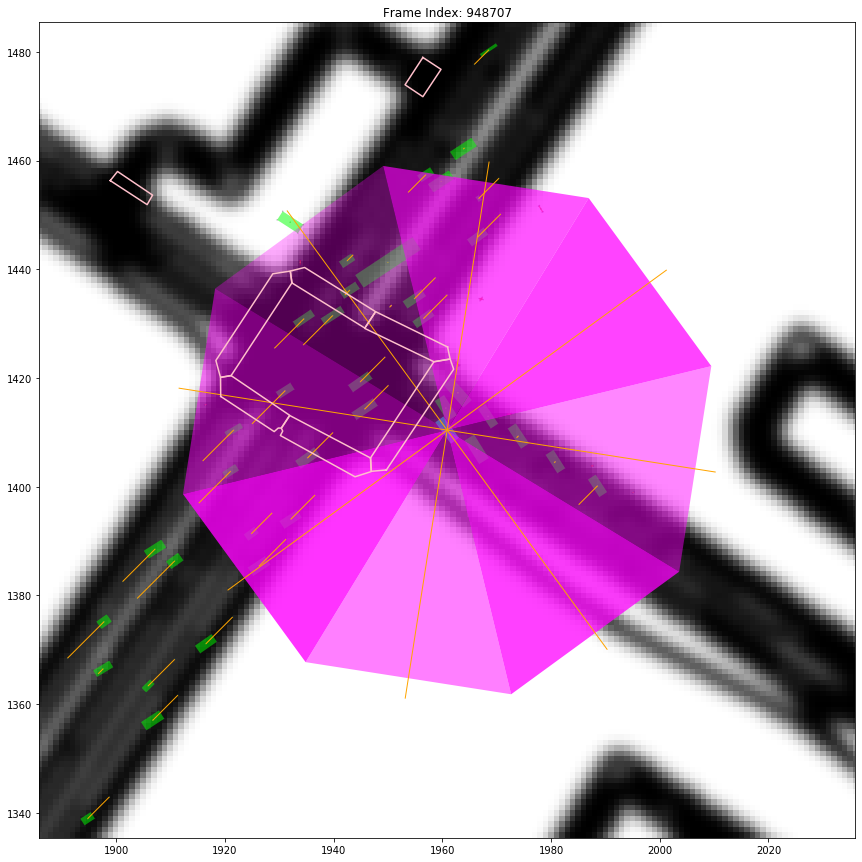

In [107]:
wheel_matrix1 = finalize_wheel_matrix(wheel_matrix)
trajectories+=wheel_matrix1

xlim_lower,xlim_upper,ylim_lower,ylim_upper=visualization_dimensions(agents_temp_frame)

# Inputs are 

# agents_temp_frame, agents_temp_frame_results
# trajectories, points, agent_polygons

# limits
# possible_entity_types_ohe

# Actual_roadmap_arr

fig, ax = plt.subplots(1,1,figsize=(15,15))

# anchor limit
ax.set_xlim(xlim_lower,xlim_upper)
ax.set_ylim(ylim_lower,ylim_upper)

# crosswalks
for i in pd.unique(cw_df.cw_id): plot_cw(cw_df,i,ax)

# adding the "wheel matrix"

lc = mc.LineCollection(trajectories, colors="orange", linewidths=1)
ax.add_collection(lc)

ax.scatter(points[:,0],points[:,1],s=0.1,c=points[:,2],alpha=0.5)

coll = PolyCollection(agent_polygons, fc=possible_entity_types_ohe,edgecolors='none')
ax.add_collection(coll)

# lets see
path_slices = slicing_results_dict["pathObjs"]
path_colors = slicing_results_dict["alternating_colors"]
pathcoll = mc.PathCollection(path_slices, fc=path_colors,edgecolors='none')
ax.add_collection(pathcoll)

#ax.autoscale_view()
#ax.grid(b=True, which='major') #<-- plot grid lines
ax.imshow(Actual_roadmap_arr[::-1], cmap="gray")
ax.set_title("Frame Index: {0}".format(str(frame_index_temp)))

In [125]:
assert (frame_df["frame_index"].value_counts()==1).all()

In [129]:
scene_indices = []
frame_indices = []
angle_availabilities = []
bad_scene_indices = []
bad_frame_indices = []

scene_index_set = pd.unique(scene_frame_agents_df["scene_index"])
scene_index_set_len = len(scene_index_set)
for i in range(scene_index_set_len):
    if ((i+1)%5==0): 
        print(i+1, scene_index_set_len)
    scene_index = scene_index_set[i]
    for frame_index in pd.unique(scene_frame_agents_df[scene_frame_agents_df["scene_index"]==scene_index]["frame_index"]):
        try:
            slice_dict = data_inspect_NO_VISUALS(scene_frame_agents_df,frame_index)
            angle_availability = slice_dict["sliceAverageDotProducts"]
            angle_availabilities.append(angle_availability)
            scene_indices.append(scene_index)
            frame_indices.append(frame_index)
        except:
            bad_scene_indices.append(scene_index)
            bad_frame_indices.append(frame_index)

5 100
10 100
15 100
20 100
25 100
30 100
35 100
40 100
45 100
50 100
55 100
60 100
65 100
70 100
75 100
80 100
85 100
90 100
95 100
100 100


In [132]:
np.array(angle_availabilities).shape

(303, 8)

In [ ]:
angle_availabilities_df = pd.DataFrame()
angle_availabilities_df["scene_index"] = scene_indices
angle_availabilities_df["frame_index"] = frame_indices
angle_availabilities_df["angle_availabilities"] = angle_availabilities


In [133]:
scene_frame_agents_df[["frame_index","scene_index"]].drop_duplicates()

,frame_index,scene_index
0,27814,112
54,27815,112
114,27816,112
176,27817,112
234,27818,112
...,...,...
1974712,3969521,15982
1974793,3969522,15982
1974871,3969523,15982
1974947,3969524,15982


#### Data Inspection: Consistency Variation

In [144]:
used_entity_types_column_names  = ['PERCEPTION_LABEL_UNKNOWN',
 'PERCEPTION_LABEL_CAR',
 'PERCEPTION_LABEL_CYCLIST',
 'PERCEPTION_LABEL_PEDESTRIAN']

In [145]:
consistency_column_names = []
consistency_column_names += ["extent_x","extent_y"]
consistency_column_names += ["length_width_ratio"]
consistency_column_names += ["scene_index","track_id"]+["frame_index"] # dont remove, is a dummy column for counting 
consistency_column_names += used_entity_types_column_names

In [146]:
consistency_df = scene_frame_agents_df[consistency_column_names]
consistency_df["length_width_ratio"] = consistency_df["extent_x"]/consistency_df["extent_y"]

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
consistency_df["length_width_ratio"] = consistency_df["extent_x"]/consistency_df["extent_y"]

In [147]:
from scipy.stats import variation

def variation(x): 
    xmean = x.mean()
    xdivmean = xmean+(xmean==0)
    xstd = np.nan_to_num(x.std(),0)
    return xstd/xdivmean

variation = ["std","mean"]

agg_consistency_column_names = []
agg_consistency_column_names += ["extent_x","extent_y"]
agg_consistency_column_names += ["length_width_ratio"]
agg_consistency_column_names += used_entity_types_column_names
agg_dict_consistency = dict()
agg_dict_consistency.update(dict(
    [(column_name, variation) for column_name in agg_consistency_column_names]))
agg_dict_consistency.update({"frame_index": "count"})

In [148]:
consistency_groupby = (
    (consistency_df
    ).groupby(["scene_index","track_id"]).agg(agg_dict_consistency)
)
consistency_groupby = consistency_groupby.fillna(0) # allowed; standard deviation of singleton arrays = 0

In [149]:
consistency_groupby.columns = consistency_groupby.columns.to_flat_index()
stdev_mean_columns = consistency_groupby.columns

In [150]:
for column_name in agg_consistency_column_names:
    consistency_groupby[column_name] = (
        (consistency_groupby[(column_name, 'std')].fillna(0)
        )/(consistency_groupby[(column_name, 'mean')].replace(0, 1))
    )

In [151]:
consistency_groupby = consistency_groupby.drop(columns=stdev_mean_columns)

extent_x 0.9820745393100809
extent_y 0.9887617165083211
length_width_ratio 0.991352101001084
PERCEPTION_LABEL_UNKNOWN 0.9823375629662692
PERCEPTION_LABEL_CAR 0.9973777338519416
PERCEPTION_LABEL_CYCLIST 0.9995536568258624
PERCEPTION_LABEL_PEDESTRIAN 0.9984377988905184


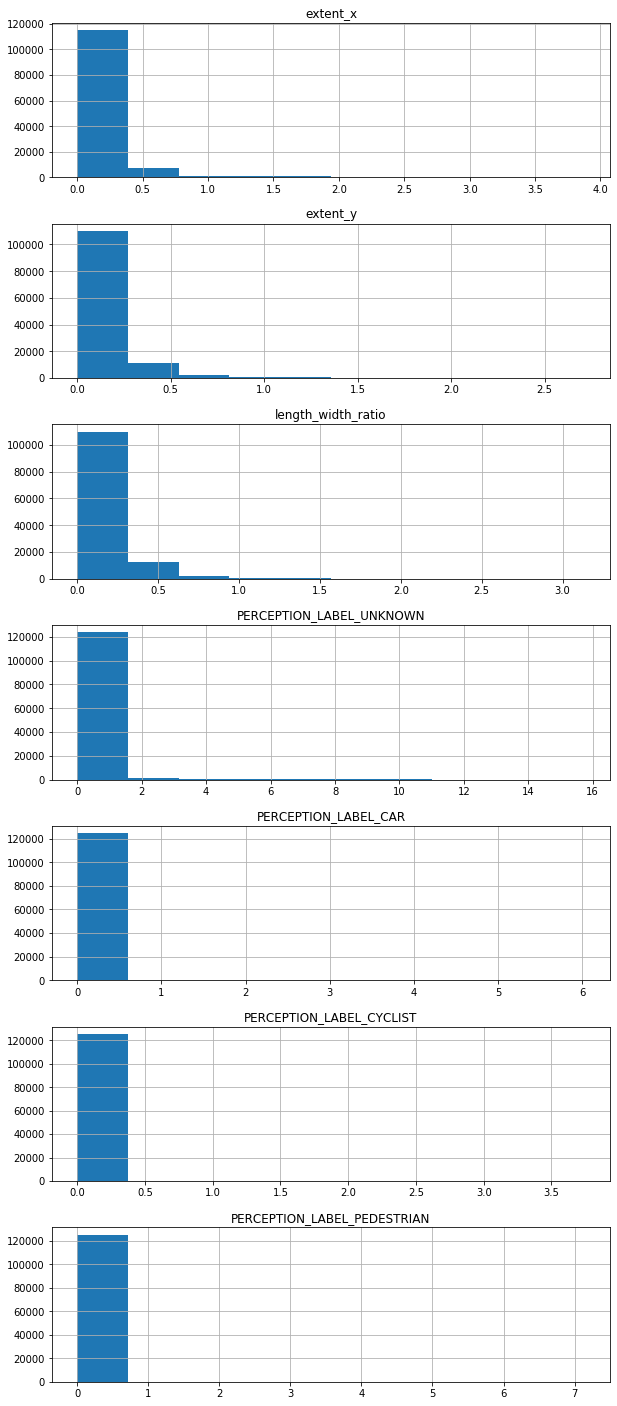

In [161]:
fig, axes = plt.subplots(len(consistency_groupby.columns),1,figsize=(10,25))
for i in range(len(consistency_groupby.columns)):
    consistency_groupby_column_name = consistency_groupby.columns[i]
    consistency_groupby.hist(consistency_groupby_column_name, ax=axes[i])
    print(consistency_groupby_column_name, (consistency_groupby[consistency_groupby_column_name]<1).mean())

plt.show()


In [ ]:
# get rid of unused columns?
# get rid of 18.5 long cars?
# impute? (hard)
# onroad only? (hard)

In [40]:
entity_types_column_names = [ 'PERCEPTION_LABEL_NOT_SET', 'PERCEPTION_LABEL_UNKNOWN',
       'PERCEPTION_LABEL_DONTCARE', 'PERCEPTION_LABEL_CAR',
       'PERCEPTION_LABEL_VAN', 'PERCEPTION_LABEL_TRAM', 'PERCEPTION_LABEL_BUS',
       'PERCEPTION_LABEL_TRUCK', 'PERCEPTION_LABEL_EMERGENCY_VEHICLE',
       'PERCEPTION_LABEL_OTHER_VEHICLE', 'PERCEPTION_LABEL_BICYCLE',
       'PERCEPTION_LABEL_MOTORCYCLE', 'PERCEPTION_LABEL_CYCLIST',
       'PERCEPTION_LABEL_MOTORCYCLIST', 'PERCEPTION_LABEL_PEDESTRIAN',
       'PERCEPTION_LABEL_ANIMAL', 'AVRESEARCH_LABEL_DONTCARE']

used_entity_types_column_names = (agents_df[ohe_entity_types_column_names]!=0).mean()
used_entity_types_column_names = list(used_entity_types_column_names[(used_entity_types_column_names!=0)].index)
unused_entity_types_column_names = set(entity_types_column_names).difference(set(used_entity_types_column_names))

In [58]:
agents_df = agents_df.drop(columns = unused_entity_types_column_names)

In [68]:
used_entity_types_column_names

['PERCEPTION_LABEL_UNKNOWN',
 'PERCEPTION_LABEL_CAR',
 'PERCEPTION_LABEL_CYCLIST',
 'PERCEPTION_LABEL_PEDESTRIAN']

In [71]:
temp_entity_categ_choices = []
temp_entity_categ_choices += ['PERCEPTION_LABEL_CAR']
temp_entity_categ_choices += ['PERCEPTION_LABEL_CYCLIST']

In [81]:
np.where(agents_df[used_entity_types_column_names].median(axis=1)==0.25)

(array([  28627,   28701,   28773,  125353,  127858,  717505,  717567,
         764323, 1224419, 1224487, 1224558, 1282715, 1282777, 1282837,
        1356766, 1356821, 1356877, 1463127, 1472329, 1559807, 1559884,
        1559962, 1700489, 1700546, 1700603, 1945645], dtype=int64),)

In [77]:
((agents_df[temp_entity_categ_choices])>0.5).all(axis=1)

False

In [70]:
temp_entity_categ_choices = []
temp_entity_categ_choices += ['PERCEPTION_LABEL_CAR']
temp_entity_categ_choices += ['PERCEPTION_LABEL_CYCLIST']
#temp_entity_categ_choices += ['PERCEPTION_LABEL_PEDESTRIAN']
#temp_entity_categ_choices += ['PERCEPTION_LABEL_UNKNOWN']

agents_df_temp_entity_categ = agents_df[()]

print(agents_df_temp_entity_categ["extent_x"].median()) # the x is the car length
print(agents_df_temp_entity_categ["extent_y"].median())
fig, axes = plt.subplots(1, 2)

agents_df_temp_entity_categ.hist("extent_x", ax=axes[0])
agents_df_temp_entity_categ.hist("extent_y", ax=axes[1])

plt.show()

KeyError: ()

In [60]:
# https://ops.fhwa.dot.gov/Freight/publications/size_regs_final_rpt/
# max length allowed is 22.86 meters
# max width allowed is 2.44 meters

In [61]:
MAX_VEHICULAR_LENGTH_METERS = 22.86
MAX_VEHICULAR_WIDTH_METERS = 2.44

In [62]:
agents_df_filtered_index = []
agents_df_filtered_booleans = 1
agents_df_filtered_booleans &= (agents_df["PERCEPTION_LABEL_CAR"] != 0)
agents_df_filtered_booleans &= ((agents_df["extent_x"]> MAX_VEHICULAR_LENGTH_METERS) | (agents_df["extent_y"]> MAX_VEHICULAR_WIDTH_METERS))

In [66]:
agents_df_cars = agents_df[(agents_df["PERCEPTION_LABEL_CAR"] != 0)]

In [67]:
agents_df_cars = agents_df[(agents_df["PERCEPTION_LABEL_CAR"] != 0)]

In [ ]:
unused_agents_df_column_names = 

In [ ]:
agents_df = agents_df.drop(unused_entity_types_column_names)

In [29]:
used_entity_types_column_names

PERCEPTION_LABEL_UNKNOWN       0.662394
PERCEPTION_LABEL_CAR           0.309705
PERCEPTION_LABEL_CYCLIST       0.006788
PERCEPTION_LABEL_PEDESTRIAN    0.025789
dtype: float64

(array([1.792208e+06, 1.326200e+05, 1.626000e+04, 5.839000e+03,
        2.347000e+03, 8.600000e+02, 8.500000e+01, 1.000000e+01,
        4.000000e+00, 1.000000e+01]),
 array([1.74091465e-03, 4.49596570e+00, 8.99019049e+00, 1.34844153e+01,
        1.79786401e+01, 2.24728649e+01, 2.69670896e+01, 3.14613144e+01,
        3.59555392e+01, 4.04497640e+01, 4.49439888e+01]),
 <a list of 10 Patch objects>)

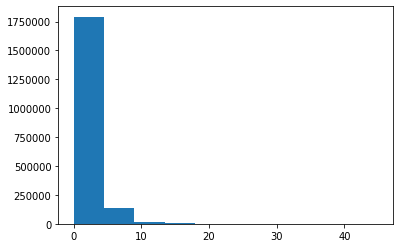

In [11]:
plt.hist(agents_df["extent_x"])

(array([1.840819e+06, 7.257300e+04, 1.742700e+04, 8.045000e+03,
        4.320000e+03, 3.476000e+03, 2.201000e+03, 1.294000e+03,
        5.400000e+01, 3.400000e+01]),
 array([1.47290656e-03, 3.36376763e+00, 6.72606236e+00, 1.00883571e+01,
        1.34506518e+01, 1.68129465e+01, 2.01752413e+01, 2.35375360e+01,
        2.68998307e+01, 3.02621254e+01, 3.36244202e+01]),
 <a list of 10 Patch objects>)

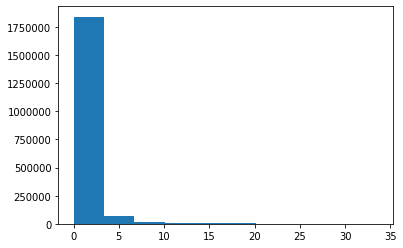

In [12]:
plt.hist(agents_df["extent_y"])